In [1]:
import scanpy as sc
import scIB
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
exec(open("../../scIB/tests/utils.py").read())

In [5]:
adata = create_adata_dummy(pca=True, n_top_genes=2000, neighbors=True)
sc.tl.umap(adata)

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


HVG
Computed 2000 highly variable genes
PCA
Nearest Neigbours


In [6]:
# remove batches from cell type
repl = (2, 4)
adata.obs['batch'] = [repl[1] 
                      if row['celltype'] == '4Ery' and row['batch'] == repl[0]
                      else row['batch']
                      for _, row in adata.obs.iterrows()]

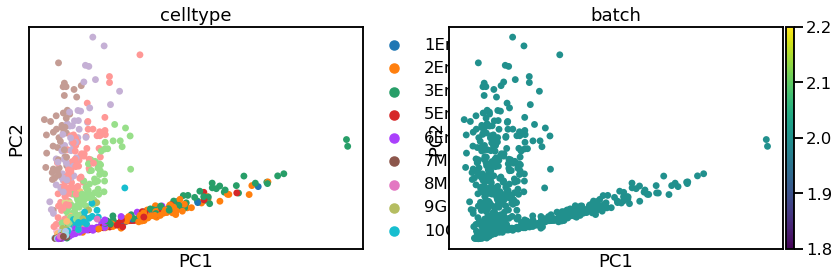

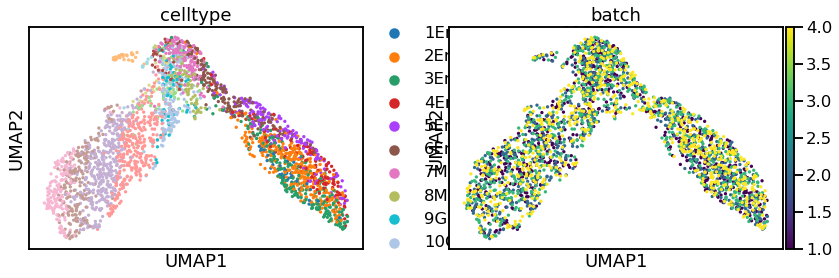

In [7]:
sc.pl.pca(adata[adata.obs['batch'] == 2], color=['celltype', 'batch'], palette=sc.pl.palettes.vega_20_scanpy)
sc.pl.umap(adata, color=['celltype', 'batch'], palette=sc.pl.palettes.vega_20_scanpy)

Get cell type labels that are in only a single batch

In [29]:
n_batch = adata.obs['batch'].nunique()
n_batch

4

In [30]:
obs_subset = adata.obs[['celltype', 'batch']].drop_duplicates()
batch_per_celltype = obs_subset.groupby('celltype').agg({'batch': "count"})
batch_per_celltype.head()

,batch
celltype,
1Ery,4
2Ery,4
3Ery,4
4Ery,3
5Ery,4


In [31]:
isolated_ct = batch_per_celltype.query('batch < @n_batch').index.tolist()

In [32]:
isolated_ct

['4Ery']

For each label compute:

+ clustering opt s.t. number of label in largest cluster is maximal
+ F1 score

In [57]:
def max_label_per_batch(adata, label_key, group_key, label):
    sub = adata.obs[adata.obs[label_key] == label].copy()
    return sub[group_key].value_counts().max()

In [43]:
sc.tl.louvain(adata, resolution=0.2, key_added='cluster')

In [58]:
max_label_per_batch(adata, 'celltype', 'cluster', '4Ery')

119

In [65]:
opt_louvain(adata, 'celltype', 'cluster', function=scIB.me.nmi, force=True)

optimised clustering against celltype
optimal cluster resolution: 2.0
optimal score: 0


(2.0, 0,     resolution     score
 0          0.1  0.415608
 1          0.2  0.415608
 2          0.3  0.473780
 3          0.4  0.465165
 4          0.5  0.478581
 5          0.6  0.490205
 6          0.7  0.484648
 7          0.8  0.496481
 8          0.9  0.497105
 9          1.0  0.469569
 10         1.1  0.473354
 11         1.2  0.482254
 12         1.3  0.489825
 13         1.4  0.492131
 14         1.5  0.489768
 15         1.6  0.485954
 16         1.7  0.489482
 17         1.8  0.496719
 18         1.9  0.493349
 19         2.0  0.496146)

In [63]:
opt_louvain(adata, 'celltype', 'cluster', function=max_label_per_batch, label='4Ery', force=True)

Compute TP, FP and F1-score